We implement a high-resolution multispectral and low-resolution hyperspectral fusion algorithm inspired by "Multispectral and Hyperspectral Image Fusion Using a 3-D-Convolutional Neural Network" from Palsson et al (https://arxiv.org/pdf/1706.05249.pdf).  


In [1]:
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from PIL import Image

import matplotlib.pyplot as plt

import os

from load_HSI_data import load_HSI_data

We apply the algorithm on simulated data built from the Pavia University dataset. We create the synthetic data as follows
- the LR HS data is the decimated data 
- the HR MS data is simulated by averaging the values of HS in 4 bands

The initial Pavia University dataset is the target HR HS image.

In [2]:
data_name = 'paviaU'
data, raw_gt, labels_id_raw, n_classes_raw, _, _ = load_HSI_data(data_name)

data = data.permute(2,0,1)
n_bands,raw_n_x,raw_n_y = data.shape
print(n_bands,raw_n_x,raw_n_y)
# make sure that the data is decimable twice (by factor 4)
n_x = raw_n_x - raw_n_x%8
n_y = raw_n_y - raw_n_y%8
print(n_x,n_y)
data = data[:,:n_x,:n_y]

data = data/data.max()


103 610 340
608 336


Let's have a look at a band of the data:

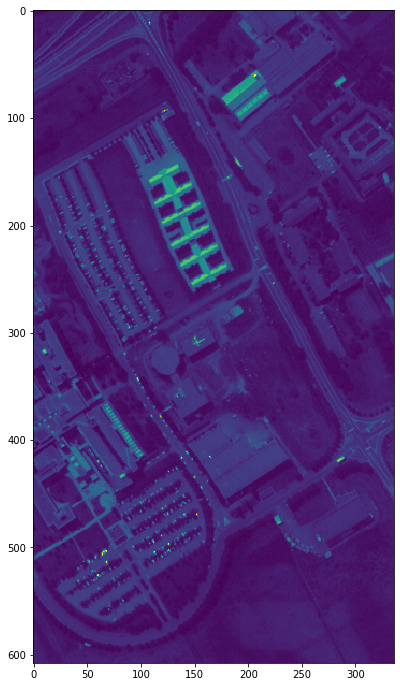

In [3]:

plt.figure(figsize=(16, 12))
plt.imshow(data[10,:,:])
plt.show()

We choose a resolution factor of 4, we use the resize function from torchvision.transforms to decimate or interpolate images.

As in practical situations, we do not have access to the HR HS image, we consider the LR HS as the target for the training stage. The groundtruth is thus decimated twice while the he HR MS is decimated once. This is standard referred as the Wald's protocol and relies on the assumption that the relationship between low and high resolution learned by the network does not depend drastically on scales.

Once the training is done, we use the neural network to generate an estimation of the HR HS image from the LR HS and HR MS. 


In [4]:

decimate_HR_image = torchvision.transforms.Resize((n_x//4,n_y//4), interpolation=Image.BICUBIC)
decimate_LR_image = torchvision.transforms.Resize((n_x//8,n_y//8), interpolation=Image.BICUBIC)
interpolate_LR_image = torchvision.transforms.Resize((n_x,n_y), interpolation=Image.BICUBIC)
interpolate_2LR_image = torchvision.transforms.Resize((n_x//4,n_y//4), interpolation=Image.BICUBIC)


In [5]:

# to do: find the indeces corresponding to each band:
X_MS = torch.zeros(4,n_x,n_y)
for i in range(4):
    X_MS[i,:,:] = torch.mean(data[i*n_bands//4:(i+1)*n_bands//4,:,:],axis=0)

X_MS_train = decimate_HR_image(X_MS)

X_HS = decimate_HR_image(data) 
X_HS_GT = data

X_HS_matrix = X_HS.view(n_bands,-1)
u, s, v = torch.svd(X_HS_matrix)


rank = 15

G_r = (torch.diag(s[:rank]) @ v[:,:rank].T).view(rank,n_x//4,n_y//4)

G_r_tilde = interpolate_2LR_image(decimate_LR_image(G_r))

print(X_MS_train.shape)
print(G_r_tilde.shape)
print(G_r.shape)

torch.Size([4, 152, 84])
torch.Size([15, 152, 84])
torch.Size([15, 152, 84])


In [6]:
print(X_MS_train.unfold(1,7,1).unfold(2,7,1).shape)
print(X_MS.unfold(1,28,4).unfold(2,28,4).shape[1])
print(X_MS.unfold(1,28,4).unfold(2,28,4).shape[2])

X_unfold = X_MS_train.unfold(1,7,1).unfold(2,7,1).reshape(4,-1,7,7)


torch.Size([4, 146, 78, 7, 7])
146
78


In [7]:
class fusion3DCNN_dataset(torch.utils.data.Dataset):

    def __init__(self, X, G, target):
        ps = 7
        n_MS_bands = X.shape[0]
        n_G_bands = G.shape[0]
        self.X_unfold = X.unfold(1,ps,1).unfold(2,ps,1).reshape(n_MS_bands,-1,ps,ps)                    #data
        self.G_unfold = G.unfold(1,ps,1).unfold(2,ps,1).reshape(n_G_bands,-1,ps,ps)                    #data
        self.target_unfold = target.unfold(1,ps,1).unfold(2,ps,1).reshape(n_G_bands,-1,ps,ps)  #GT
    def __len__(self):
        return self.X_unfold.shape[1]

    def __getitem__(self, idx):
        patch_X_MS = self.X_unfold[:,idx,:,:]
        patch_G = self.G_unfold[:,idx,:,:]
        patch_target = self.target_unfold[:,idx,:,:]
        return torch.cat((patch_X_MS, patch_G),dim=0), patch_target

class CONV3DNet(nn.Module):
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv1d):
            nn.init.uniform_(m.weight, -0.05, 0.05)
            nn.init.zeros_(m.bias)
    
    def __init__(self, k1, k2, k3, rank):
        super(CONV3DNet, self).__init__()
        self.zeroPadding3D = nn.ConstantPad3d(1, 0)
        self.C1 = nn.Conv3d(1, 32, k1)#,padding=1)
        self.C2 = nn.Conv3d(32, 64, k2)#,padding=1)
        self.C3 = nn.Conv3d(64, 1, k3,dilation=(4,2,2),padding=(0,1,1))
        self.apply(self.weight_init)
        
    def forward(self, x):
        #x = x.squeeze(dim=-1).squeeze(dim=-1)
        x = x.unsqueeze(dim=1)
        x = self.zeroPadding3D(x)
        x = F.relu(self.C1(x))
        if self.training:
            x + torch.randn(x.size())*0.001
        x = self.zeroPadding3D(x)
        x = F.relu(self.C2(x))
        if self.training:
            x + torch.randn(x.size())*0.001
        x = self.C3(x)
        return x


In [8]:
batch_size=20

trainset = fusion3DCNN_dataset(X_MS_train, G_r_tilde, G_r)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
for i, batch in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    X, patch_G_r = batch
    break
print(X.shape)
print(patch_G_r.shape)


k1, k2, k3 = 3,3,2
model = CONV3DNet(k1, k2, k3, rank)

optimizer = optim.Adam(model.parameters(), lr=0.0002)
n_epoch = 50
criterion = nn.MSELoss()



torch.Size([20, 19, 7, 7])
torch.Size([20, 15, 7, 7])


Sanity check: we assess that our network is at least able to overfit a single batch:

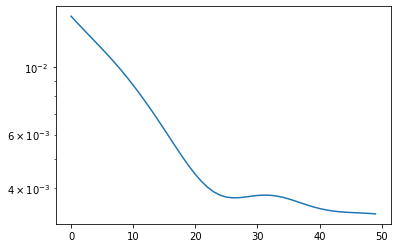

In [9]:
losss_overfitting = torch.zeros(n_epoch)
X, target = next(iter(trainloader))

model.train()

for epoch in range(n_epoch):  # loop over the dataset multiple times
    optimizer.zero_grad()
    outputs = model(X.float())
    loss = criterion(outputs.squeeze(1), target.float())
    loss.backward()
    optimizer.step()
    losss_overfitting[epoch] = loss.detach()/batch_size
plt.semilogy(losss_overfitting)

We are now ready to train the network:

 [50] loss: 0.000837  
Finished Training


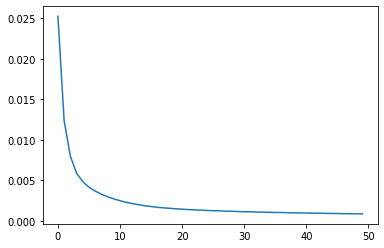

In [10]:
losses = torch.zeros(n_epoch)
model.train()
for epoch in range(n_epoch):  # loop over the dataset multiple times
    running_loss = 0
    for i, batch in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        X, target = batch
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(X.float())
        loss = criterion(outputs.squeeze(1), target.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses[epoch] = running_loss/len(trainloader)
    print('\r [%d] loss: %.6f ' %
          (epoch + 1, losses[epoch]), end='' )
print(' ')
print('Finished Training')
plt.plot(losses)

We first evaluate the network by applying it on the twice decimated HS images (this is in fact the train set, we are just doing a sanity check):

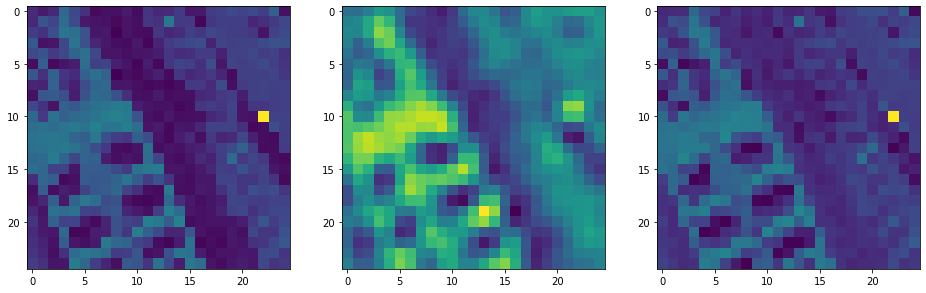

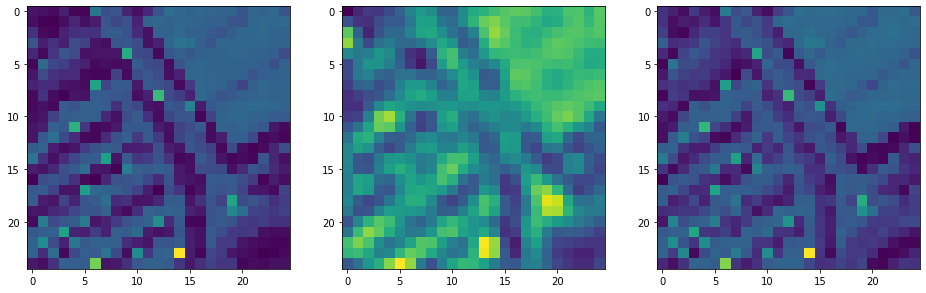

In [11]:
X_eval = torch.cat((X_MS_train, G_r_tilde)).unsqueeze(dim=0)
model.eval()
output_eval = model(X_eval.float())


Estimated_LR_HS = (u[:,:rank] @ output_eval[0,0,:,:].view(rank,-1).double()).reshape(n_bands,n_x//4,n_y//4)
HS_2LR = (u[:,:rank] @ G_r_tilde.view(rank,-1)).reshape(n_bands,n_x//4,n_y//4)

for x_idx,y_idx in zip([25,100],[25,25]):
    plt.figure(figsize=(16, 12))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(Estimated_LR_HS[60,x_idx:x_idx+25,y_idx:y_idx+25].detach())
    ax = plt.subplot(1, 3, 2)
    plt.imshow(HS_2LR[60,x_idx:x_idx+25,y_idx:y_idx+25].detach())
    ax = plt.subplot(1, 3, 3)
    plt.imshow(X_MS_train[2,x_idx:x_idx+25,y_idx:y_idx+25].detach())
    plt.show()


Finally, we check that the network is able to produce HS HS images from LR HS images and HR MS images:
    

In [12]:
G_r_int_HR = interpolate_LR_image(G_r)
X_test = torch.cat((X_MS,G_r_int_HR)).unsqueeze(dim=0)

model.eval()
output_test = model(X_test.float())

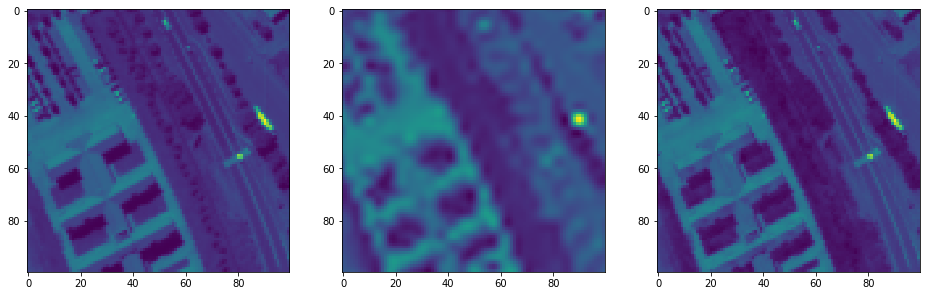

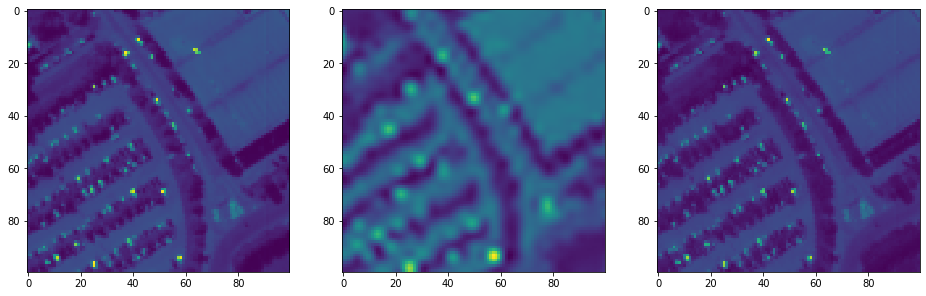

In [13]:
Estimated_HR_HS = (u[:,:rank] @ output_test[0,0,:,:].view(rank,-1).double()).reshape(n_bands,n_x,n_y)

for x_idx,y_idx in zip([100,400],[100,100]):
    plt.figure(figsize=(16, 12))
    ax = plt.subplot(1, 3, 1)
    plt.imshow(X_MS[2,x_idx:x_idx+100,y_idx:y_idx+100].detach())

    ax = plt.subplot(1, 3, 2)
    plt.imshow(interpolate_LR_image(X_HS)[60,x_idx:x_idx+100,y_idx:y_idx+100].detach())

    ax = plt.subplot(1, 3, 3)
    plt.imshow(Estimated_HR_HS[60,x_idx:x_idx+100,y_idx:y_idx+100].detach())
    plt.show()


Let's check if our network is able to fuse the Pavia Center image:

102 300 200


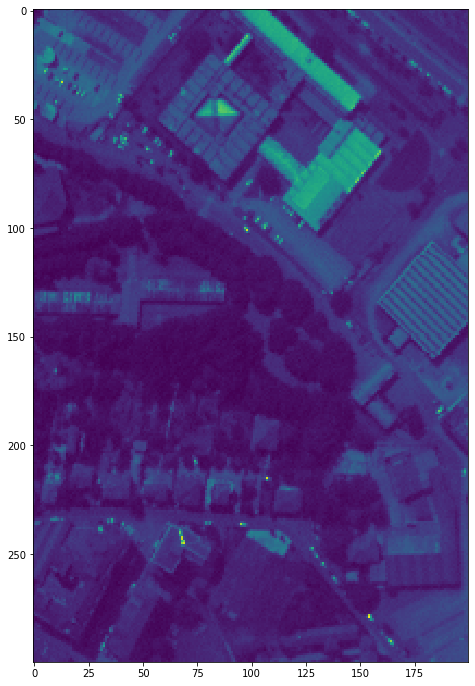

In [14]:
data_name = 'pavia'
data, raw_gt, labels_id_raw, n_classes_raw, _, _ = load_HSI_data(data_name)

data = data.permute(2,0,1)
data = data[:,400:700,400:600]

n_bands,n_x,n_y = data.shape
print(n_bands,n_x,n_y)

data = data/data.max()


plt.figure(figsize=(16, 12))
plt.imshow(data[10,:,:])
plt.show()


In [15]:
decimate_HR_image = torchvision.transforms.Resize((n_x//4,n_y//4), interpolation=Image.BICUBIC)
interpolate_LR_image = torchvision.transforms.Resize((n_x,n_y), interpolation=Image.BICUBIC)

X_HS = decimate_HR_image(data)

X_HS_matrix = X_HS.view(n_bands,-1)
u, s, v = torch.svd(X_HS_matrix)

G_r = (torch.diag(s[:rank]) @ v[:,:rank].T).view(rank,n_x//4,n_y//4)

G_r_int_HR = interpolate_LR_image(G_r)

X_MS = torch.zeros(4,n_x,n_y)
for i in range(4):
    X_MS[i,:,:] = torch.mean(data[i*n_bands//4:(i+1)*n_bands//4,:,:],axis=0)

X_test = torch.cat((X_MS,G_r_int_HR)).unsqueeze(dim=0)

model.eval()
output_test = model(X_test.float())


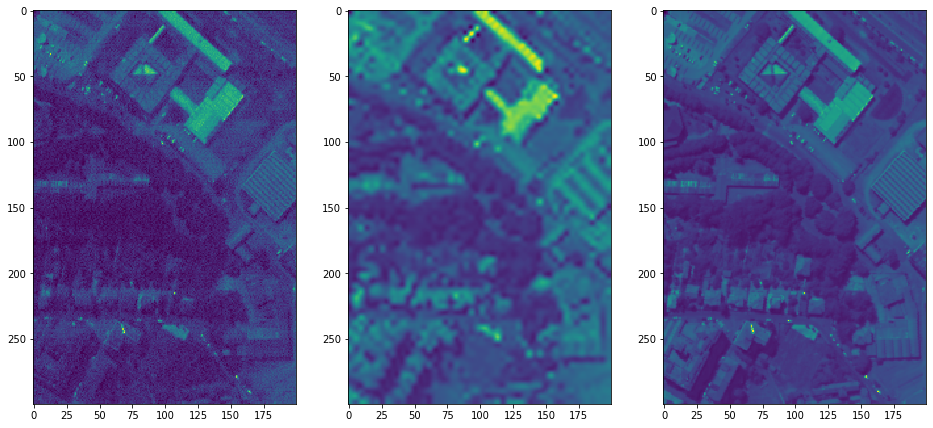

In [16]:
Estimated_HR_HS = (u[:,:rank] @ output_test[0,0,:,:].view(rank,-1).double()).reshape(n_bands,n_x,n_y)

plt.figure(figsize=(16, 12))

ax = plt.subplot(1, 3, 1)
plt.imshow(data[2,:,:].detach())

ax = plt.subplot(1, 3, 2)
plt.imshow(interpolate_LR_image(X_HS)[40,:,:].detach())

ax = plt.subplot(1, 3, 3)
plt.imshow(Estimated_HR_HS[40,:,:].detach())
plt.show()
